# ATP Tennis Data

In previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/3-atp_basic_feature_engineering.ipynb) we did some feature engineering and created our file with ~57k entries for training if we take data from 1998 to now

In this notebook, we will load this dataset in and run logistic regression on our datasets and see what our accuracy is.

Null Hypothesis:
Our null hypothesis is an accuracy of ~65%. This is derived from if we were to purely use the player rank to predict winner. We will use this as our baseline for evaluating our models.

Metric:
* Since this is binary classification, we will use training accuracy to evaluate our model

Findings:
* Logistic Regression is not able to derive relationship between player 1 and player 2 status automatically - ie, rank, seed, height. This performs similarly to our null hypothesis. We find that we diff these stats and created features from the, Logistic Regression's performance improved
* Adding more historical data (ie, 1998 to 2019 vs 1985 to 2019) actually makes the model perform worse if we don't use one hot encoding. This could possibly be caused by the fact that player match behavior is changing over time and older match data deviates more from current match behavior
    * While using one hot encoding when we only looked at dataset from 1998 to 2019 made our model perform worse, we see that when we look at the entire dataset from 1985 to 2019, our model performance actually improves. This actually gave us the higest accruacy score of 68.8% as opposed to using player stats diff with dataset from 1998 to 2019 (68.5%). However, due to data size and time to train the model, I think it will be a better bet to not use one hot encoding for logistic regression so you can iterate faster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import pickle
import json

%matplotlib inline
sns.set()

In [20]:
# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# files
DATASET_DIR = '../datasets'
FEATURE_FILE_1985 = f'{DATASET_DIR}/atp_matches_1985-2019_features-raw.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'
MODEL_DIR = '../models'
MODEL_FILE = f'{MODEL_DIR}/{DATE}-lr.csv'
MODEL_FILE = f'{MODEL_DIR}/{DATE}-lr-diff.csv'

REPORT_DIR = '../reports'
REFPORT_FILE = f'{REPORT_DIR}/report.csv'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 1000



# Testing Feature Set 1

This feature set, we have both p1 and p2 statistics

In [3]:
features_orig = pd.read_csv(FEATURE_FILE_1998)
features_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57868 entries, 0 to 57867
Data columns (total 22 columns):
draw_size              57868 non-null int64
p1                     57868 non-null int64
p1_age                 57868 non-null float64
p1_hand                57868 non-null int64
p1_ht                  57868 non-null float64
p1_ioc                 57868 non-null int64
p1_rank                57868 non-null int64
p1_seed                57868 non-null int64
p1_winner              57868 non-null int64
p2                     57868 non-null int64
p2_age                 57868 non-null float64
p2_hand                57868 non-null int64
p2_ht                  57868 non-null float64
p2_ioc                 57868 non-null int64
p2_rank                57868 non-null int64
p2_seed                57868 non-null int64
round_label            57868 non-null int64
surface_label          57868 non-null int64
tourney_id_label       57868 non-null int64
tourney_level_label    57868 non-null int64
tou

In [4]:
features = features_orig
labels = features[LABEL_COL].copy()
features = features.drop([LABEL_COL], axis=1)

In [5]:
labels.head()

0    1
1    1
2    0
3    0
4    0
Name: p1_winner, dtype: int64

In [6]:
features.head().T

,0,1,2,3,4
draw_size,32.00,32.00,32.00,32.00,32.00
p1,102035.00,101727.00,102491.00,101647.00,102104.00
p1_age,25.79,27.76,23.08,28.25,25.37
p1_hand,1.00,1.00,1.00,1.00,1.00
p1_ht,183.00,185.00,185.00,175.00,188.00
p1_ioc,70.00,3.00,32.00,83.00,54.00
p1_rank,4.00,79.00,71.00,76.00,65.00
p1_seed,1.00,24.00,18.00,21.00,16.00
p2,101917.00,102548.00,102765.00,102563.00,102796.00
p2_age,26.61,22.85,21.76,22.79,21.60


## Split into training and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=RSTATE)
print(f'Training size {len(y_train)} test size {len(y_test)}')

Training size 43401 test size 14467


In [8]:
lr = LogisticRegression(n_jobs = N_JOBS, verbose = 1, max_iter = MAX_ITER, random_state = RSTATE, solver = 'lbfgs').fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


In [9]:
y_predict = lr.predict(X_test)
y_predict[:10]

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [10]:
print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.65      0.65      0.65      7224
         Win       0.65      0.65      0.65      7243

    accuracy                           0.65     14467
   macro avg       0.65      0.65      0.65     14467
weighted avg       0.65      0.65      0.65     14467



      Loss   Win
Loss  4722  2502
Win   2560  4683


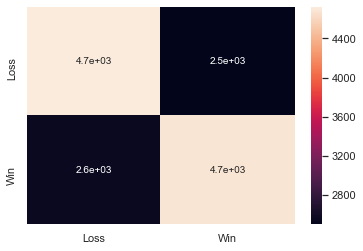

In [11]:
cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], columns = ['Loss', 'Win'])
print(cm)
sns.heatmap(cm, annot=True)

### Logistic Regression with just player stats does not perform any better than our null hypothesis

# Test Our Feature Set 2 - Diff player stats

This feature set uses difference in player stats

In [12]:
# extract features and labels
features_diff = pd.read_csv(FEATURE_FILE_1998_DIFF)
labels_diff = features_diff[LABEL_COL].copy()
features_diff = features_diff.drop([LABEL_COL], axis=1)

# train our model
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(features_diff, labels_diff, random_state=RSTATE)
lr_diff = LogisticRegression(n_jobs = N_JOBS, verbose = 1, max_iter = MAX_ITER, random_state = RSTATE, solver = 'lbfgs').fit(X_train_diff, y_train_diff)
y_predict_diff = lr_diff.predict(X_test_diff)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.8s finished


In [33]:
lr_diff.score(X_test_diff, y_test_diff)

0.6856984862099952

In [13]:
print(classification_report(y_test_diff, y_predict_diff, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.69      0.66      0.68      7115
         Win       0.68      0.71      0.70      7352

    accuracy                           0.69     14467
   macro avg       0.69      0.69      0.69     14467
weighted avg       0.69      0.69      0.69     14467



      Loss   Win
Loss  4724  2391
Win   2156  5196


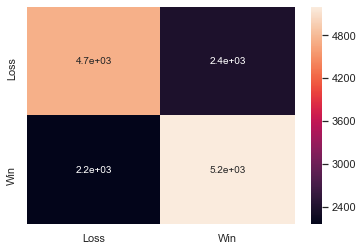

In [14]:
cm_diff = pd.DataFrame(confusion_matrix(y_test_diff, y_predict_diff), index=['Loss', 'Win'], columns = ['Loss', 'Win'])
print(cm_diff)
sns.heatmap(cm_diff, annot=True)

## Feature Importance

Use statsmodel to look at our feature importance

## Feature Set 2 Summary

We are seeing a slight improvement on the diff data set (set 2). It looks like logistic regression is not able to pick up relationship between columns to make predictions (ie, player 1 rank vs player 2 rank)

We see precision increase of about 3 to 4% and recall improvement from 1% to 6% and increase of f1 score from 3 to 5%

We should be using this feature engineering technique for future data and models

# Feature Set 3 - 1985 to 2019

I created a 3rd dataset based in the player stats diff feature engineering technique. However, for this dataset, instead starting the data from 1998. This dataset starts at 1985 and have about 99k entries

In [15]:
# extract features and labels
features_1985diff = pd.read_csv(FEATURE_FILE_1985_DIFF)
labels_1985diff = features_1985diff[LABEL_COL].copy()
features_1985diff = features_1985diff.drop([LABEL_COL], axis=1)

# train our model
X_train_1985diff, X_test_1985diff, y_train_1985diff, y_test_1985diff = \
        train_test_split(features_1985diff, labels_1985diff, random_state=RSTATE)
lr_1985diff = LogisticRegression(n_jobs = N_JOBS, 
                                 verbose = 1, 
                                 max_iter = MAX_ITER, 
                                 random_state = RSTATE, 
                                 solver = 'lbfgs').fit(X_train_1985diff, y_train_1985diff)
y_predict_1985diff = lr_1985diff.predict(X_test_1985diff)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.5s finished


In [16]:
print(classification_report(y_test_1985diff, y_predict_1985diff, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.69      0.66      0.68     12502
         Win       0.67      0.71      0.69     12487

    accuracy                           0.68     24989
   macro avg       0.68      0.68      0.68     24989
weighted avg       0.68      0.68      0.68     24989



      Loss   Win
Loss  8249  4253
Win   3670  8817


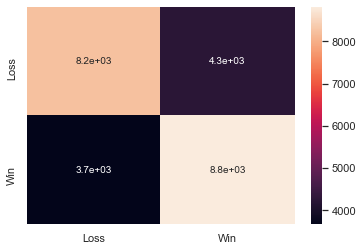

In [17]:
cm_1985diff = pd.DataFrame(confusion_matrix(y_test_1985diff, y_predict_1985diff), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
print(cm_1985diff)
sns.heatmap(cm_1985diff, annot=True)

# Dataset 3 Summary

Interesting. With more previous data, our precision and recall actually decreased by 1% as well as our macro average.

It is possible that the game is changing over time. Older data may not represent data that you would get today and does not provide more information to help us predict current behavior

Let's look at one more thing - expected win percentage over the past 3 decades to see how likely a better ranked player will win a match.

You can see that over the past 3 decades, this number is becoming more significant

In [18]:
# let's calculated all matches that we expected to win and did win
preprocessed1985 = pd.read_csv(f'{DATASET_DIR}/atp_matches_1985-2019_preprocessed.csv', parse_dates=["tourney_date"])
preprocessed1985['expected_win'] = preprocessed1985.apply(lambda x: 1 if x.winner_rank < x.loser_rank else 0, axis=1)

# now let's look at them by decade
m90s = preprocessed1985[(preprocessed1985.tourney_date >= datetime(1990, 1, 1)) &
                (preprocessed1985.tourney_date < datetime(2001, 1, 1))]
m00s = preprocessed1985[(preprocessed1985.tourney_date >= datetime(2000, 1, 1)) &
                (preprocessed1985.tourney_date < datetime(2011, 1, 1))]
m10s = preprocessed1985[(preprocessed1985.tourney_date >= datetime(2010, 1, 1))]


print(f'Expected win percentage - 90s: {m90s.expected_win.sum()/len(m90s)}')
print(f'Expected win percentage - 00s: {m00s.expected_win.sum()/len(m00s)}')
print(f'Expected win percentage - 10s: {m10s.expected_win.sum()/len(m10s)}')


Expected win percentage - 90s: 0.6414095011619737
Expected win percentage - 00s: 0.6485231401042489
Expected win percentage - 10s: 0.6635793495867426


# Dataset 4 - One Hot Encoded (1998 to 2019)

We will run this dataset through LR and see if we get improvements through One Hot Encoding our non-oridnal categorical features

In [21]:
features_1998_diff_ohe = pd.read_csv(FEATURE_FILE_1998_DIFF_OHE)
# filter out rows before 1998
features_1998_diff_ohe = features_1998_diff_ohe[features_1998_diff_ohe.tourney_year >= 1998]
labels_1998_diff_ohe = features_1998_diff_ohe[LABEL_COL].copy()
features_1998_diff_ohe = features_1998_diff_ohe.drop([LABEL_COL], axis=1)



In [22]:


# train our model
X_train_1998_diff_ohe, X_test_1998_diff_ohe, y_train_1998_diff_ohe, y_test_1998_diff_ohe = \
        train_test_split(features_1998_diff_ohe, labels_1998_diff_ohe, random_state=RSTATE)
lr_1998_diff_ohe = LogisticRegression(n_jobs = N_JOBS, 
                                 verbose = 1, 
                                 max_iter = MAX_ITER, 
                                 random_state = RSTATE, 
                                 solver = 'lbfgs').fit(X_train_1998_diff_ohe, y_train_1998_diff_ohe)
y_predict_1998_diff_ohe = lr_1998_diff_ohe.predict(X_test_1998_diff_ohe)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 37.5min finished


In [23]:
lr_1998_diff_ohe.score(X_test_1998_diff_ohe, y_test_1998_diff_ohe)

0.6695223961144091

In [24]:
print(classification_report(y_test_1998_diff_ohe, y_predict_1998_diff_ohe, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.67      0.66      0.67      7378
         Win       0.67      0.68      0.67      7446

    accuracy                           0.67     14824
   macro avg       0.67      0.67      0.67     14824
weighted avg       0.67      0.67      0.67     14824



      Loss   Win
Loss  4869  2509
Win   2390  5056


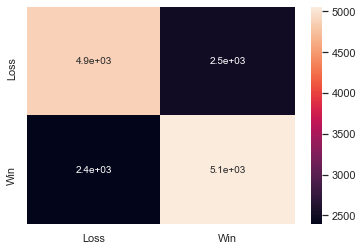

In [25]:
cm_1998_diff_ohe = pd.DataFrame(confusion_matrix(y_test_1998_diff_ohe, y_predict_1998_diff_ohe), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
print(cm_1998_diff_ohe)
sns.heatmap(cm_1998_diff_ohe, annot=True)

# Dataset 4.1 - One Hot Encoded (1985 to 2019)

In [27]:
features_1985_diff_ohe = pd.read_csv(FEATURE_FILE_1985_DIFF_OHE)
labels_1985_diff_ohe = features_1985_diff_ohe[LABEL_COL].copy()
features_1985_diff_ohe = features_1985_diff_ohe.drop([LABEL_COL], axis=1)



# train our model
X_train_1985_diff_ohe, X_test_1985_diff_ohe, y_train_1985_diff_ohe, y_test_1985_diff_ohe = \
        train_test_split(features_1985_diff_ohe, labels_1985_diff_ohe, random_state=RSTATE)
lr_1985_diff_ohe = LogisticRegression(n_jobs = N_JOBS, 
                                 verbose = 1, 
                                 max_iter = MAX_ITER, 
                                 random_state = RSTATE, 
                                 solver = 'lbfgs').fit(X_train_1985_diff_ohe, y_train_1985_diff_ohe)
y_predict_1985_diff_ohe = lr_1985_diff_ohe.predict(X_test_1985_diff_ohe)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  5.1min finished


In [28]:
lr_1985_diff_ohe.score(X_test_1985_diff_ohe, y_test_1985_diff_ohe)

0.6882228180399376

In [30]:
print(classification_report(y_test_1985_diff_ohe, y_predict_1985_diff_ohe, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.70      0.67      0.68     12502
         Win       0.68      0.71      0.69     12487

    accuracy                           0.69     24989
   macro avg       0.69      0.69      0.69     24989
weighted avg       0.69      0.69      0.69     24989



      Loss   Win
Loss  8354  4148
Win   3643  8844


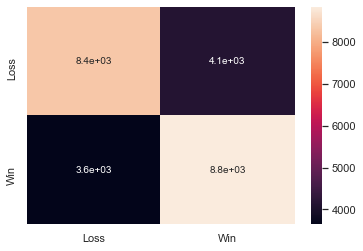

In [32]:
cm_1985_diff_ohe = pd.DataFrame(confusion_matrix(y_test_1985_diff_ohe, y_predict_1985_diff_ohe), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
print(cm_1985_diff_ohe)
sns.heatmap(cm_1985_diff_ohe, annot=True)

# Our Null Hypothesis

Before we being, let's define our null hypothesis. Our hypothesis is that if p1 has ranking lower than p2, p1 should win.

First, let's get a sense of how often upsets happen - ie, player with higher rank wins a match against player with lower rank

For this we have to load the dataset before we created the features and encoded everything

Looks like 65% of ATP matches are won by players with lower rank - this will be our benchmark for our models

In [36]:
null_labels = features_1985diff.apply(lambda x: 1 if x["rank_diff"] < 0 else 0, axis=1)

In [37]:
print(classification_report(labels_1985diff, null_labels, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.66      0.65      0.65     50265
         Win       0.65      0.65      0.65     49690

    accuracy                           0.65     99955
   macro avg       0.65      0.65      0.65     99955
weighted avg       0.65      0.65      0.65     99955



       Loss    Win
Loss  32791  17474
Win   17265  32425


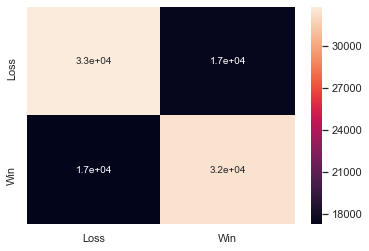

In [38]:
cm = pd.DataFrame(confusion_matrix(labels_1985diff, null_labels), index=['Loss', 'Win'], columns = ['Loss', 'Win'])
print(cm)
sns.heatmap(cm, annot=True)